In [1]:
from sqlalchemy import create_engine
import api_keys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

In [2]:
24 * 60 / 5

288.0

In [3]:
DB_USER = api_keys.DB_USER
DB_PASS = api_keys.DB_PASS
DB_URL = api_keys.DB_URL

engine = create_engine("mysql+pymysql://{0}:{1}@{2}".format(DB_USER, DB_PASS, DB_URL), echo=True) 
connection = engine.connect()

statement = """SELECT * FROM dublin_bikes.availability, dublin_bikes.weather_current
where availability.number = 2 && weather_current.station_number = 2 && timestampdiff(MINUTE,availability.time_queried, weather_current.time_queried) < 5 && timestampdiff(MINUTE,availability.time_queried, weather_current.time_queried) > 0
""" # create select statement for stations table

2021-03-27 13:42:48,440 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-03-27 13:42:48,442 INFO sqlalchemy.engine.base.Engine {}
2021-03-27 13:42:48,565 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-03-27 13:42:48,567 INFO sqlalchemy.engine.base.Engine {}
2021-03-27 13:42:48,806 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-03-27 13:42:48,808 INFO sqlalchemy.engine.base.Engine {}
2021-03-27 13:42:49,048 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8mb4' and `Collation` = 'utf8mb4_bin'
2021-03-27 13:42:49,050 INFO sqlalchemy.engine.base.Engine {}
2021-03-27 13:42:49,174 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-03-27 13:42:49,176 INFO sqlalchemy.engine.base.Engine {}
2021-03-27 13:42:49,298 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-03-27 13:42:49,299 INFO sqlalchemy.engine.base.E

In [4]:
df = pd.read_sql_query(statement, engine) # https://stackoverflow.com/questions/29525808/sqlalchemy-orm-conversion-to-pandas-dataframe

2021-03-27 13:42:50,397 INFO sqlalchemy.engine.base.OptionEngine SELECT * FROM dublin_bikes.availability, dublin_bikes.weather_current
where availability.number = 2 && weather_current.station_number = 2 && timestampdiff(MINUTE,availability.time_queried, weather_current.time_queried) < 5 && timestampdiff(MINUTE,availability.time_queried, weather_current.time_queried) > 0

2021-03-27 13:42:50,399 INFO sqlalchemy.engine.base.OptionEngine {}


In [5]:
print("Mb:", sys.getsizeof(df)/ (2 ** 20))

Mb: 2.0196447372436523


In [ ]:
# the following notebook is based off material presented in Data Analytics module COMP47350 labs 7 and 9

In [6]:
df.head(5)

,number,available_bikes,available_bike_stands,last_update,station_status,time_queried,station_number,time_queried,last_update,temp,feels_like,pressure,humidity,visibility,wind_speed,wind_deg,weather_main,weather_description
0,2,10,10,2021-02-25 17:21:00,OPEN,2021-02-25 17:22:34,2,2021-02-25 17:24:24,2021-02-25 17:24:17,282,278,1029,66.0,10000,3,240,Clouds,scattered clouds
1,2,10,10,2021-02-25 17:21:00,OPEN,2021-02-25 17:27:35,2,2021-02-25 17:29:45,2021-02-25 17:29:43,281,278,1029,66.0,10000,3,240,Clouds,scattered clouds
2,2,9,11,2021-02-25 17:30:22,OPEN,2021-02-25 17:32:37,2,2021-02-25 17:34:56,2021-02-25 17:34:54,281,278,1029,66.0,10000,3,240,Clouds,scattered clouds
3,2,9,11,2021-02-25 17:30:22,OPEN,2021-02-25 17:37:38,2,2021-02-25 17:40:08,2021-02-25 17:40:06,281,278,1029,66.0,10000,3,240,Clouds,scattered clouds
4,2,9,11,2021-02-25 17:40:30,OPEN,2021-02-25 17:42:39,2,2021-02-25 17:45:19,2021-02-25 17:45:18,281,277,1029,66.0,10000,4,270,Clouds,scattered clouds


In [7]:
df.dtypes

number                            int64
available_bikes                   int64
available_bike_stands             int64
last_update                      object
station_status                   object
time_queried             datetime64[ns]
station_number                    int64
time_queried             datetime64[ns]
last_update              datetime64[ns]
temp                              int64
feels_like                        int64
pressure                          int64
humidity                        float64
visibility                        int64
wind_speed                        int64
wind_deg                          int64
weather_main                     object
weather_description              object
dtype: object

In [8]:
categorical_columns = df[['weather_description','weather_main','station_number','number','station_status']].columns
# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')  

continuous_columns = df.select_dtypes(['int64']).columns
datetime_columns = df.select_dtypes(['datetime64[ns]']).columns

df.dtypes

number                         category
available_bikes                   int64
available_bike_stands             int64
last_update                      object
station_status                 category
time_queried             datetime64[ns]
station_number                 category
time_queried             datetime64[ns]
last_update              datetime64[ns]
temp                              int64
feels_like                        int64
pressure                          int64
humidity                        float64
visibility                        int64
wind_speed                        int64
wind_deg                          int64
weather_main                   category
weather_description            category
dtype: object

In [9]:
df["humidity"] = df["humidity"].fillna(0)

In [10]:
df.corr()

,available_bikes,available_bike_stands,temp,feels_like,pressure,humidity,visibility,wind_speed,wind_deg
available_bikes,1.000000,-0.968409,0.009994,0.078629,0.218425,0.295071,0.058551,-0.115759,-0.019393
available_bike_stands,-0.968409,1.000000,-0.005556,-0.075982,-0.223736,-0.328347,-0.001038,0.119966,0.054200
temp,0.009994,-0.005556,1.000000,0.845773,0.000912,-0.276256,0.279280,0.302194,0.296617
feels_like,0.078629,-0.075982,0.845773,1.000000,0.366811,-0.044838,0.154213,-0.223236,0.127302
pressure,0.218425,-0.223736,0.000912,0.366811,1.000000,0.398670,-0.124781,-0.682838,-0.189749
humidity,0.295071,-0.328347,-0.276256,-0.044838,0.398670,1.000000,-0.489851,-0.425284,-0.436901
visibility,0.058551,-0.001038,0.279280,0.154213,-0.124781,-0.489851,1.000000,0.197539,0.350284
wind_speed,-0.115759,0.119966,0.302194,-0.223236,-0.682838,-0.425284,0.197539,1.000000,0.356395
wind_deg,-0.019393,0.054200,0.296617,0.127302,-0.189749,-0.436901,0.350284,0.356395,1.000000


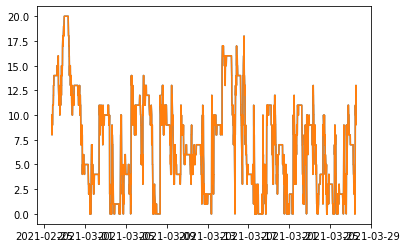

In [11]:
plt.plot(df["time_queried"],df["available_bikes"])

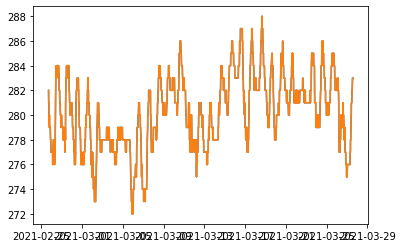

In [12]:
plt.plot(df["time_queried"],df["temp"])

In [13]:
weather_dummies = pd.get_dummies(df['weather_main'], prefix='weather_main', drop_first=True)

In [14]:
df = pd.get_dummies(df, drop_first=True)

In [15]:
df.head(5)

,available_bikes,available_bike_stands,time_queried,time_queried,last_update,temp,feels_like,pressure,humidity,visibility,...,weather_description_clear sky,weather_description_few clouds,weather_description_fog,weather_description_heavy intensity rain,weather_description_light intensity drizzle,weather_description_light rain,weather_description_mist,weather_description_moderate rain,weather_description_overcast clouds,weather_description_scattered clouds
0,10,10,2021-02-25 17:22:34,2021-02-25 17:24:24,2021-02-25 17:24:17,282,278,1029,66.0,10000,...,0,0,0,0,0,0,0,0,0,1
1,10,10,2021-02-25 17:27:35,2021-02-25 17:29:45,2021-02-25 17:29:43,281,278,1029,66.0,10000,...,0,0,0,0,0,0,0,0,0,1
2,9,11,2021-02-25 17:32:37,2021-02-25 17:34:56,2021-02-25 17:34:54,281,278,1029,66.0,10000,...,0,0,0,0,0,0,0,0,0,1
3,9,11,2021-02-25 17:37:38,2021-02-25 17:40:08,2021-02-25 17:40:06,281,278,1029,66.0,10000,...,0,0,0,0,0,0,0,0,0,1
4,9,11,2021-02-25 17:42:39,2021-02-25 17:45:19,2021-02-25 17:45:18,281,277,1029,66.0,10000,...,0,0,0,0,0,0,0,0,0,1


In [16]:
pd.get_dummies(df, drop_first=True).columns

Index(['available_bikes', 'available_bike_stands', 'time_queried',
       'time_queried', 'last_update', 'temp', 'feels_like', 'pressure',
       'humidity', 'visibility',
       ...
       'weather_description_clear sky', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_heavy intensity rain',
       'weather_description_light intensity drizzle',
       'weather_description_light rain', 'weather_description_mist',
       'weather_description_moderate rain',
       'weather_description_overcast clouds',
       'weather_description_scattered clouds'],
      dtype='object', length=3572)

In [18]:
# Prepare the descriptive features
#print(df.head(10))
cont_features = ['temp', 'wind_speed', 'pressure', 'humidity']
categ_features = weather_dummies.columns.values.tolist()
features = cont_features + categ_features
X = df[features]
y = df.available_bikes

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
       temp  wind_speed  pressure  humidity  weather_main_Clouds  \
0      282           3      1029      66.0                    1   
1      281           3      1029      66.0                    1   
2      281           3      1029      66.0                    1   
3      281           3      1029      66.0                    1   
4      281           4      1029      66.0                    1   
...    ...         ...       ...       ...                  ...   
5864   283           7      1015       0.0                    1   
5865   283           7      1015       0.0                    1   
5866   283           7      1015       0.0                    1   
5867   283           7      1015       0.0                    1   
5868   283           8      1015       0.0                    1   

      weather_main_Drizzle  weather_main_Fog  weather_main_Mist  \
0                        0                 0                  0   
1                        0      

In [44]:
# Use more features for training
# Train aka fit, a model using all continuous features.

linreg = MLPRegressor(random_state=1, max_iter=500).fit(X[features], y)

# Print the weights learned for each feature.
print("Features: \n", features)

Features: 
 ['temp', 'wind_speed', 'pressure', 'humidity', 'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog', 'weather_main_Mist', 'weather_main_Rain']


In [41]:
linreg_predictions = linreg.predict(X[features])

print("\nPredictions with linear regression: \n")
actual_vs_predicted_linreg = pd.concat([y, pd.DataFrame(linreg_predictions, columns=['Predicted'], index=y.index)], axis=1)
print(actual_vs_predicted_linreg)


Predictions with linear regression: 

      available_bikes  Predicted
0                  10  11.831307
1                  10  11.871010
2                   9  11.871010
3                   9  11.871010
4                   9  11.958963
...               ...        ...
5864               13   5.831281
5865               12   5.831281
5866               11   5.831281
5867               12   5.831281
5868               12   5.930295

[5869 rows x 2 columns]


In [42]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))
        

In [43]:
printMetrics(y, linreg_predictions)


MAE:  3.4658327006224856
RMSE:  4.179804363898697
R2:  0.22706785490361714


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Training data:\n", pd.concat([X_train, y_train], axis=1))
print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

Training data:
       temp  wind_speed  pressure  humidity  weather_main_Clouds  \
70     277           3      1033      87.0                    1   
2104   280           5      1023       0.0                    0   
1752   272           1      1035       0.0                    1   
4539   282           5      1032       0.0                    1   
3839   282           4      1036       0.0                    1   
...    ...         ...       ...       ...                  ...   
4931   281           4      1019       0.0                    1   
3264   282           8      1017       0.0                    1   
1653   277           3      1033       0.0                    1   
2607   279           6       990       0.0                    1   
2732   277           9       997       0.0                    0   

      weather_main_Drizzle  weather_main_Fog  weather_main_Mist  \
70                       0                 0                  0   
2104                     0                 0 

In [36]:
# Train on the training sample and test on the test sample.
linreg = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
# Print the weights learned for each feature.
#print(linreg_train.coef_)

In [37]:
X_train

,temp,wind_speed,pressure,humidity,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Mist,weather_main_Rain
70,277,3,1033,87.0,1,0,0,0,0
2104,280,5,1023,0.0,0,0,0,0,1
1752,272,1,1035,0.0,1,0,0,0,0
4539,282,5,1032,0.0,1,0,0,0,0
3839,282,4,1036,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
4931,281,4,1019,0.0,1,0,0,0,0
3264,282,8,1017,0.0,1,0,0,0,0
1653,277,3,1033,0.0,1,0,0,0,0
2607,279,6,990,0.0,1,0,0,0,0


In [38]:
# Predicted price on training set
train_predictions = linreg.predict(X_train)
print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, train_predictions)

Actual vs predicted on training:
       available_bikes  Predicted
70                 14  10.925890
2104               11   6.256002
1752               11   7.241478
4539                8   6.501897
3839                0   6.431619
...               ...        ...
4931                7   5.742939
3264               16   6.561633
1653                3   6.846505
2607                7   5.160896
2732                7   6.536090

[4108 rows x 2 columns]

MAE:  3.4776322267743294
RMSE:  4.169296738822935
R2:  0.24254092173455055


In [39]:
# Predicted price on test set
test_predictions = linreg.predict(X_test)
print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1))
printMetrics(y_test, test_predictions)

Actual vs predicted on test:
       available_bikes  Predicted
4771                7   5.927957
3948                3   6.207656
2372                4   5.108091
4793                7   5.827225
1121               10  10.451962
...               ...        ...
2260                4   4.985007
1115               10  10.451962
3829                0   6.264073
5013                6   5.907898
2615                5   5.315460

[1761 rows x 2 columns]

MAE:  3.4567110586301846
RMSE:  4.150914632162206
R2:  0.20949196356995303
